In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from datetime import date
from functools import reduce

In [2]:
df = pd.read_csv('tweets_users_period_simple.csv')
df.head()

,id,user_id,to_date
0,1006016894560763904,27823262,2018-06-11
1,1006017578194612224,27823262,2018-06-11
2,1006120674786725888,17322758,2018-06-11
3,1006125685675646976,17322758,2018-06-11
4,1006130726725672960,17322758,2018-06-11


## Topical signal

In [3]:
df['to_date'] = pd.to_datetime(df['to_date'])

In [4]:
d0 = df['to_date'].min()
d1 = df['to_date'].max()
delta = d1 - d0
print(delta.days)

147


In [5]:
df_agg = df[['user_id','id']].groupby('user_id')\
                             .count()\
                             .reset_index()\
                             .rename({'id':'topic_signal'}, axis='columns')
df_agg.head()

,user_id,topic_signal
0,12750,4
1,950531,216
2,1586871,47
3,1938691,34
4,2354081,30


In [6]:
df_agg['avg_topic_signal']  = df_agg['topic_signal'].apply(lambda x: x/delta.days)
df_agg.head()

,user_id,topic_signal,avg_topic_signal
0,12750,4,0.027211
1,950531,216,1.469388
2,1586871,47,0.319728
3,1938691,34,0.231293
4,2354081,30,0.204082


## Milestones Interest

From the peak detection notebook, the following milestones and their weights were calculated:

- 2018-07-10: 2
- 2018-09-05: 2
- 2018-09-24: 4
- 2018-09-27: 10
- 2018-10-06: 7

In [7]:
milestones_weights = {'2018-07-10': 2,
                      '2018-09-05': 2,
                      '2018-09-24': 4,
                      '2018-09-27': 10,
                      '2018-10-06': 7}
milestones_weights

{'2018-07-10': 2,
 '2018-09-05': 2,
 '2018-09-24': 4,
 '2018-09-27': 10,
 '2018-10-06': 7}

In [8]:
dfm = pd.read_csv('tweets_milestones.csv')
dfm.head()

,id,user_id,to_date
0,1016491072090976256,27823262,2018-07-10
1,1016492014744014848,27823262,2018-07-10
2,1016658957505630208,2815413319,2018-07-10
3,1037128173882941440,143196450,2018-09-05
4,1037146029878136832,21584887,2018-09-05


In [9]:
topical_signal_milestones = []
dates = dfm['to_date'].unique()

for date in dates:
    dfm_sub = dfm.loc[dfm['to_date'] == date]
    df_user_count = dfm_sub[['user_id','id']].groupby('user_id').count().reset_index().rename({'id':date}, axis=1)
    topical_signal_milestones.append(df_user_count)

In [10]:
dfm_merge = reduce(lambda df1, df2: df1.merge(df2, "outer"), topical_signal_milestones)
dfm_merge = dfm_merge.fillna(0)
dfm_merge.head()

,user_id,2018-07-10,2018-09-05,2018-09-24,2018-09-27,2018-10-06
0,950531,1.0,0.0,0.0,0.0,0.0
1,6586772,1.0,0.0,0.0,0.0,0.0
2,17028405,1.0,0.0,0.0,0.0,0.0
3,22223902,1.0,1.0,0.0,1.0,0.0
4,22225649,1.0,0.0,0.0,0.0,1.0


In [11]:
df_merge_agg = pd.merge(dfm_merge, df_agg, how='inner', on='user_id')
df_merge_agg.head()

,user_id,2018-07-10,2018-09-05,2018-09-24,2018-09-27,2018-10-06,topic_signal,avg_topic_signal
0,950531,1.0,0.0,0.0,0.0,0.0,216,1.469388
1,6586772,1.0,0.0,0.0,0.0,0.0,25,0.170068
2,17028405,1.0,0.0,0.0,0.0,0.0,155,1.054422
3,22223902,1.0,1.0,0.0,1.0,0.0,90,0.612245
4,22225649,1.0,0.0,0.0,0.0,1.0,21,0.142857


In [12]:
df_merge_agg['MI'] = 0

In [13]:
for date in dates:
    df_merge_agg['MI'] = \
        df_merge_agg.apply(lambda x: (x['MI'] + milestones_weights[date]) \
                               if x[date] > x['avg_topic_signal'] else x['MI'], axis=1)

In [14]:
df_merge_agg.head()

,user_id,2018-07-10,2018-09-05,2018-09-24,2018-09-27,2018-10-06,topic_signal,avg_topic_signal,MI
0,950531,1.0,0.0,0.0,0.0,0.0,216,1.469388,0.0
1,6586772,1.0,0.0,0.0,0.0,0.0,25,0.170068,2.0
2,17028405,1.0,0.0,0.0,0.0,0.0,155,1.054422,0.0
3,22223902,1.0,1.0,0.0,1.0,0.0,90,0.612245,14.0
4,22225649,1.0,0.0,0.0,0.0,1.0,21,0.142857,9.0


### Interest

In [15]:
sum(milestones_weights.values())

25

In [16]:
df_merge_agg['interest'] = df_merge_agg['MI']/sum(milestones_weights.values())

In [17]:
df_merge_agg.head()

,user_id,2018-07-10,2018-09-05,2018-09-24,2018-09-27,2018-10-06,topic_signal,avg_topic_signal,MI,interest
0,950531,1.0,0.0,0.0,0.0,0.0,216,1.469388,0.0,0.00
1,6586772,1.0,0.0,0.0,0.0,0.0,25,0.170068,2.0,0.08
2,17028405,1.0,0.0,0.0,0.0,0.0,155,1.054422,0.0,0.00
3,22223902,1.0,1.0,0.0,1.0,0.0,90,0.612245,14.0,0.56
4,22225649,1.0,0.0,0.0,0.0,1.0,21,0.142857,9.0,0.36


Text(0,0.5,'N° users')

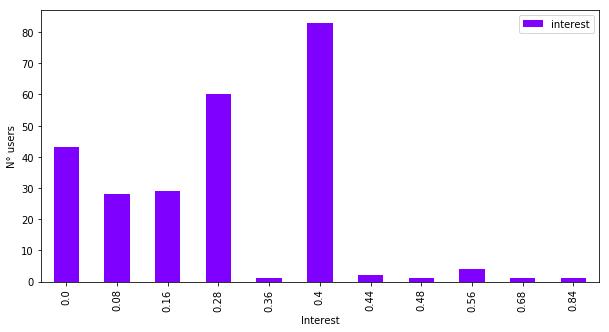

In [18]:
ax = pd.DataFrame(df_merge_agg['interest'].value_counts()).\
        reset_index().sort_values('index').plot(x='index',
                                                y='interest', 
                                                kind='bar',
                                                colormap='rainbow', figsize=(10,5))
    
ax.set_xlabel('Interest')
ax.set_ylabel('N° users')

## Exclusivity

In [19]:
df = pd.read_csv('tweets_users_period_simple.csv')
df.head()

,id,user_id,to_date
0,1006016894560763904,27823262,2018-06-11
1,1006017578194612224,27823262,2018-06-11
2,1006120674786725888,17322758,2018-06-11
3,1006125685675646976,17322758,2018-06-11
4,1006130726725672960,17322758,2018-06-11


In [20]:
# Count tweets by date
df_exc = df.groupby(by=['user_id','to_date']).count().reset_index().rename({'id':'count'}, axis='columns')
df_exc.head()

,user_id,to_date,count
0,12750,2018-07-22,1
1,12750,2018-10-06,3
2,950531,2018-06-11,3
3,950531,2018-06-12,3
4,950531,2018-06-13,3


In [21]:
df_exc_agg = pd.merge(df_exc, df_agg, how='left', on='user_id')
df_exc_agg.head()

,user_id,to_date,count,topic_signal,avg_topic_signal
0,12750,2018-07-22,1,4,0.027211
1,12750,2018-10-06,3,4,0.027211
2,950531,2018-06-11,3,216,1.469388
3,950531,2018-06-12,3,216,1.469388
4,950531,2018-06-13,3,216,1.469388


In [22]:
df_days_signal = df_exc_agg.\
                    loc[df_exc_agg['count'] > df_exc_agg['avg_topic_signal']][['user_id','count']]\
                        .groupby('user_id')\
                        .count()\
                        .reset_index()\
                        .rename({'count':'day_upper'}, axis='columns')
df_days_signal.head()

,user_id,day_upper
0,12750,2
1,950531,71
2,1586871,18
3,1938691,30
4,2354081,19


### Day upper milestones

In [23]:
dfm.head()

,id,user_id,to_date
0,1016491072090976256,27823262,2018-07-10
1,1016492014744014848,27823262,2018-07-10
2,1016658957505630208,2815413319,2018-07-10
3,1037128173882941440,143196450,2018-09-05
4,1037146029878136832,21584887,2018-09-05


In [24]:
# Count tweets by date
dfm_exc = dfm.groupby(by=['user_id','to_date']).count().reset_index().rename({'id':'count'}, axis='columns')
dfm_exc.head()

,user_id,to_date,count
0,12750,2018-10-06,1
1,950531,2018-07-10,1
2,1586871,2018-10-06,1
3,1938691,2018-09-27,1
4,2354081,2018-09-27,1


In [25]:
dfm_exc_agg = pd.merge(dfm_exc, df_agg, how='left', on='user_id')
dfm_exc_agg.head()

,user_id,to_date,count,topic_signal,avg_topic_signal
0,12750,2018-10-06,1,4,0.027211
1,950531,2018-07-10,1,216,1.469388
2,1586871,2018-10-06,1,47,0.319728
3,1938691,2018-09-27,1,34,0.231293
4,2354081,2018-09-27,1,30,0.204082


In [26]:
dfm_days_signal = dfm_exc_agg.\
                    loc[dfm_exc_agg['count'] > dfm_exc_agg['avg_topic_signal']][['user_id','count']]\
                        .groupby('user_id')\
                        .count()\
                        .reset_index()\
                        .rename({'count':'day_upper_milestones'}, axis='columns')
dfm_days_signal.head()

,user_id,day_upper_milestones
0,12750,1
1,1586871,1
2,1938691,1
3,2354081,1
4,3526251,1


In [29]:
df_final = pd.merge(df_days_signal, dfm_days_signal, how='inner', on='user_id')
df_final.head()

,user_id,day_upper,day_upper_milestones
0,12750,2,1
1,1586871,18,1
2,1938691,30,1
3,2354081,19,1
4,3526251,11,1


In [31]:
df_final['exclusivity'] = df_final.apply(lambda x: x['day_upper_milestones'] / x['day_upper'], axis=1)

In [32]:
df_final.head()

,user_id,day_upper,day_upper_milestones,exclusivity
0,12750,2,1,0.500000
1,1586871,18,1,0.055556
2,1938691,30,1,0.033333
3,2354081,19,1,0.052632
4,3526251,11,1,0.090909


In [33]:
df_final.sort_values('exclusivity', ascending=False).head()

,user_id,day_upper,day_upper_milestones,exclusivity
144,348186417,1,1,1.0
155,426653938,1,1,1.0
25,16821030,1,1,1.0
179,1172398680,1,1,1.0
106,97817378,1,1,1.0


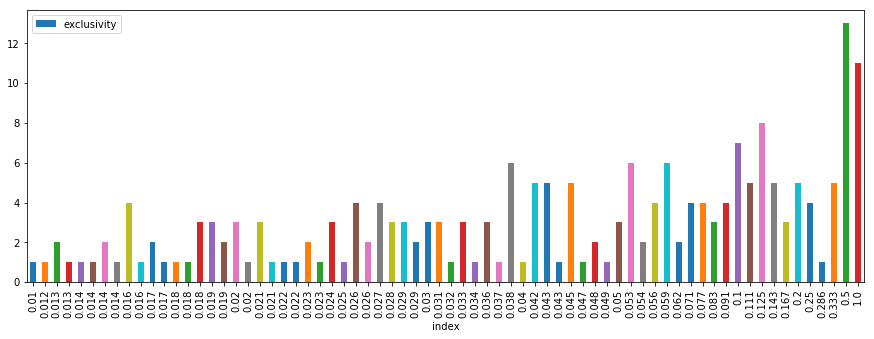

In [46]:
pd.DataFrame(df_final['exclusivity'].\
    value_counts()).reset_index().round(3).\
    sort_values('index').plot(x='index', y='exclusivity', kind='bar', figsize=(15,5))

In [49]:
df_merge_final = df_merge_agg.merge(df_final[['user_id', 'exclusivity']])
df_merge_final.head()

,user_id,2018-07-10,2018-09-05,2018-09-24,2018-09-27,2018-10-06,topic_signal,avg_topic_signal,MI,interest,exclusivity
0,6586772,1.0,0.0,0.0,0.0,0.0,25,0.170068,2.0,0.08,0.047619
1,22223902,1.0,1.0,0.0,1.0,0.0,90,0.612245,14.0,0.56,0.049180
2,22225649,1.0,0.0,0.0,0.0,1.0,21,0.142857,9.0,0.36,0.100000
3,23326014,1.0,0.0,0.0,0.0,0.0,8,0.054422,2.0,0.08,0.142857
4,24829139,1.0,0.0,0.0,0.0,0.0,48,0.326531,2.0,0.08,0.031250


In [51]:
df_merge_final['milestonesrank'] = \
    df_merge_final.apply(lambda x: x['interest'] * 0.5 + x['exclusivity'] * 0.5 , axis=1)

In [52]:
df_merge_final.head()

,user_id,2018-07-10,2018-09-05,2018-09-24,2018-09-27,2018-10-06,topic_signal,avg_topic_signal,MI,interest,exclusivity,milestonesrank
0,6586772,1.0,0.0,0.0,0.0,0.0,25,0.170068,2.0,0.08,0.047619,0.063810
1,22223902,1.0,1.0,0.0,1.0,0.0,90,0.612245,14.0,0.56,0.049180,0.304590
2,22225649,1.0,0.0,0.0,0.0,1.0,21,0.142857,9.0,0.36,0.100000,0.230000
3,23326014,1.0,0.0,0.0,0.0,0.0,8,0.054422,2.0,0.08,0.142857,0.111429
4,24829139,1.0,0.0,0.0,0.0,0.0,48,0.326531,2.0,0.08,0.031250,0.055625


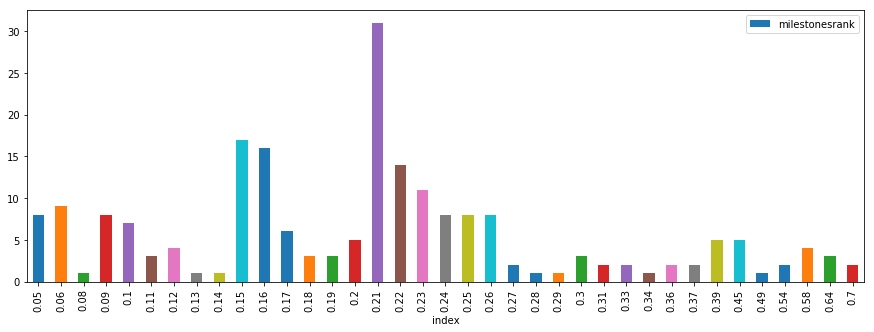

In [63]:
pd.DataFrame(df_merge_final['milestonesrank'].round(2).\
    value_counts()).reset_index().\
    sort_values('index').plot(x='index', y='milestonesrank', kind='bar', figsize=(15,5))

In [54]:
df_merge_final[['exclusivity','interest']].corr()

,exclusivity,interest
exclusivity,1.000000,-0.134338
interest,-0.134338,1.000000
